In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder
import random
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings("ignore")

# fechas
from datetime import datetime

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# algoritmos de clasificación
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# algoritmos de regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# métricas
import sklearn.metrics as metrics

# hiperparametrización
from sklearn.model_selection import GridSearchCV

# TensorFlow y tf.keras
import tensorflow as tf
from tensorflow import keras

import xgboost as xgb

from numpy import random
random.seed(42)

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Ruta al archivo Parquet 
ruta_archivo = "C:/Users/Herre/Desktop/TFM/Nuclio_EasyMoney/0_Data/df_encoding.csv"
# Leer el archivo Parquet 
df_clustering_2 = pd.read_csv(ruta_archivo)

In [3]:
# 1. Crear 'number_of_products'
# Suponiendo que cada columna de productos (como 'short_term_deposit', 'loans', etc.) tiene un valor de 0 o 1
product_columns = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 
                   'em_account_pp', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 
                   'emc_account', 'debit_card', 'em_account_p', 'em_acount']

df_clustering_2['number_of_products'] = df_clustering_2[product_columns].sum(axis=1)

# 2. Crear 'account_balance'
# Suponiendo que 'account_balance' puede inferirse de ciertas columnas relacionadas con activos financieros. 
# Si estas columnas son binarias (0/1), no podemos calcular un balance real. Ajusta esto según tus datos reales.
# Si estas columnas representan montos, simplemente suma los montos.
balance_columns = ['short_term_deposit', 'funds', 'securities', 'long_term_deposit']

df_clustering_2['account_balance'] = df_clustering_2[balance_columns].sum(axis=1)

# 3. Crear 'loan_amount'
# Suponiendo que 'loan_amount' es la suma de todas las columnas relacionadas con préstamos.
loan_columns = ['loans', 'mortgage']

df_clustering_2['loan_amount'] = df_clustering_2[loan_columns].sum(axis=1)

In [4]:
# Lista de columnas de productos con diferentes niveles de compromiso
high_commitment_products = ['pension_plan', 'emc_account', 'em_account_pp', 'em_account_p', 'em_acount']  # Productos de alto compromiso
medium_commitment_products = ['credit_card', 'debit_card']  # Productos de compromiso medio
low_commitment_products = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit', 
                           'payroll', 'payroll_account']  # Productos de bajo compromiso

# Crear 'product_engagement_score'
df_clustering_2['product_engagement_score'] = (
    df_clustering_2[high_commitment_products].sum(axis=1) * 3 +   # Productos de alto compromiso, peso 3
    df_clustering_2[medium_commitment_products].sum(axis=1) * 2 +  # Productos de compromiso medio, peso 2
    df_clustering_2[low_commitment_products].sum(axis=1)          # Productos de bajo compromiso, peso 1
)


# Columnas utilizadas para calcular la deuda total
debt_columns = ['loans', 'mortgage']

# Crear la columna 'debt_to_income_ratio'
# Evitamos la división por cero utilizando 'np.where' para manejar ingresos nulos o cero.
df_clustering_2['debt_to_income_ratio'] = df_clustering_2[debt_columns].sum(axis=1) / df_clustering_2['salary'].replace(0, np.nan)

# Reemplazar posibles NaN resultantes de la división por cero con un valor específico o dejar como NaN
df_clustering_2['debt_to_income_ratio'].fillna(0, inplace=True)

In [6]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering_2)
# Perform K-Means clustering
kmeans = KMeans(n_clusters=7, random_state=42)
df_clustering_2['cluster'] = kmeans.fit_predict(X_scaled)

In [7]:
# Definir las columnas relevantes para el clustering
summary_columns = ["salary", "loan_amount", "debt_to_income_ratio", "account_balance", "number_of_products", "product_engagement_score", 
"age", "segment", "active_customer", "region_code"]

# Inicializar el DataFrame ficha_df
ficha_df = pd.DataFrame()

# Generar los datos resumen para cada columna
for col in summary_columns:
    resumen_data = df_clustering_2[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

# Definir los componentes del multi-índice
out_index = ["Monetario"] *4  + ["Productos"] * 2 + ["Social"] * 4  # Ajusta esta lista según las columnas seleccionadas
inner_index = summary_columns
estadisticos = ["mean", "std", "min", "25%", "50%", "75%", "max"]

# Crear el nuevo multi-índice
new_multi_index = []
for oi, ii in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

# Generar el multi-índice
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names=names)

names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)

# Establecer el multi-índice en ficha_df
ficha_df.set_index(index_ficha, inplace=True)

# Calcular el tamaño de cada cluster
tamaño_clusters = df_clustering_2.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")], names), inplace=True)

# Concatenar los datos de tamaño con el DataFrame ficha_df
ficha_df = pd.concat([tamaño_clusters, ficha_df])

# Estilizar el DataFrame con un gradiente de fondo
styled_ficha_df = ficha_df.style.background_gradient(cmap='Blues', axis=1)

# Mostrar el DataFrame estilizado
styled_ficha_df

In [12]:
# Define los hiperparámetros para RandomForestClassifier
params = {
    'random_state': 42,   # Asegura la reproducibilidad del modelo
    'n_jobs': -1,         # Usa todos los núcleos del procesador para entrenar el modelo
    'n_estimators': 100,  # Número de árboles en el bosque
    'max_depth': 4        # Profundidad máxima de cada árbol
}


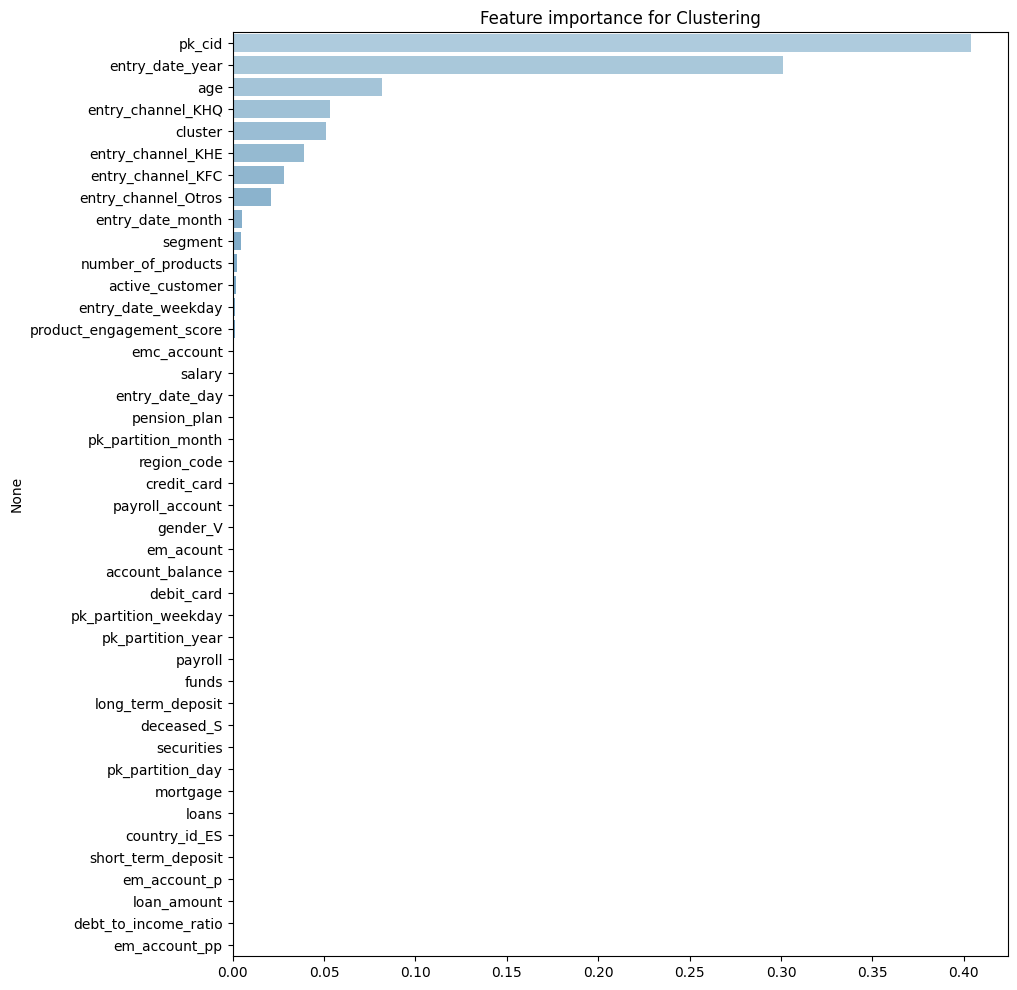

In [13]:
from sklearn.ensemble import RandomForestClassifier
# Realiza el clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_clustering_2['Cluster'] = kmeans.fit_predict(df_clustering_2.drop('Cluster', axis=1))  # Aplicar clustering después de quitar la columna simulada

# Ahora que tienes clusters reales, puedes ver la importancia de las características
x, y = df_clustering_2.drop('Cluster', axis=1), df_clustering_2['Cluster']

# Entrenar un modelo RandomForestClassifier
clf = RandomForestClassifier(**params)
clf.fit(x, y)

# Obtener las importancias de las características
feature_importances = clf.feature_importances_
columnas = x.columns

# Crear una serie de pandas para organizar las importancias
imp = pd.Series(data=feature_importances, index=columnas).sort_values(ascending=False)

# Visualizar todas las características ordenadas por importancia
plt.figure(figsize=(10, 12))
plt.title("Feature importance for Clustering")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()
